# Diagnostic Curves

Predicting probabilities instead of just classes allows us to assess model performance using a variety of diagnostic curves.

## What we will accomplish

In this notebook we will:
- Discuss how different probability cutoffs produce different classification metrics,
- Parlay that into definitions of various diagnostic curves like:
    - The precision-recall curve,
    - The receiver operating characteristic (ROC) Curve
    - A gains chart and
    - A lift chart,
- Demonstrate how to plot the various curves using `sklearn` and `matplotlib`.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

In this notebook we will work with the synthetic logistic regression problem we saw in the last notebook.

In [2]:
## Load in the randomly generated data
data = np.loadtxt("../../../Data/random_binary.csv",delimiter = ",")
X = data[:,0]
y = data[:,1]

In [3]:
from sklearn.model_selection import train_test_split

## import LogisticRegression
from sklearn.linear_model import LogisticRegression

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=435,
                                                       test_size=.2,
                                                       stratify=y)

In [5]:
## make model object
log_reg = LogisticRegression()

## fit the model
log_reg.fit(X_train.reshape(-1,1), y_train)

LogisticRegression()

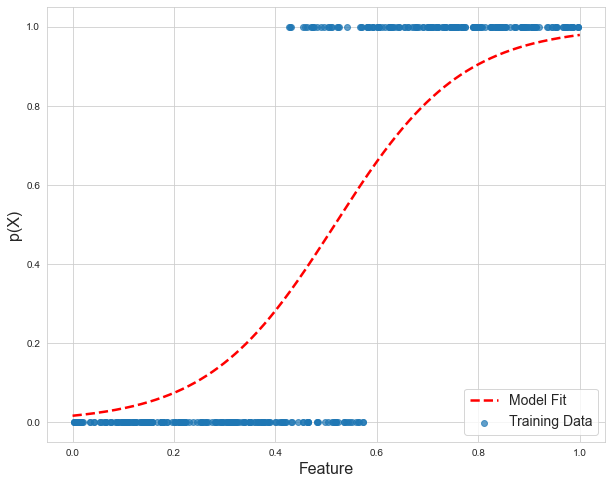

In [6]:
# Plot figure 
plt.figure(figsize = (10,8))

# With classifications we have a new method
# predict_proba which returns the probability
# that an observation is a certain class.
plt.plot(np.linspace(0,1,1000),
            log_reg.predict_proba(np.linspace(0,1,1000).reshape(-1,1))[:,1],
            'r--',linewidth=2.5,label = "Model Fit")
plt.scatter(X_train,y_train,label = 'Training Data',alpha=.7)
plt.legend(fontsize = 14,loc = 4)
plt.xlabel("Feature",fontsize = 16)
plt.ylabel("p(X)",fontsize=16) 

plt.show()

Choosing different probability cutoffs gives different confusion matrices and thus different performance metrics. Here's an example with a cutoff of $0.4$ and $0.6$ respectively.

In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
print("Confusion Matrix for a cutoff of 0.4")
print(confusion_matrix(y_train, 
                       np.int64(log_reg.predict_proba(X_train.reshape(-1,1))[:,1] >= 0.4)))

print()
print()

print("Confusion Matrix for a cutoff of 0.6")
print(confusion_matrix(y_train, 
                       np.int64(log_reg.predict_proba(X_train.reshape(-1,1))[:,1] >= 0.6)))


Confusion Matrix for a cutoff of 0.4
[[190  23]
 [  6 181]]


Confusion Matrix for a cutoff of 0.6
[[211   2]
 [ 22 165]]


As we may have suspected, increasing our cutoff increased our number of true and false negatives while decreasing our number of false and true positives. 

We could do this process for any cutoff value in $[0,1]$ which implies that all of our previously introduced performance metrics can be thought of as functions of the probability cutoff. This allows us to make series of diagnostic curves for any algorithm that we are considering.

## Precision-Recall curve

The first curve we will consider is the <i>precision-recall</i> curve. As the name suggests this curve plots the different precision scores against the different recall scores your algorithm receives as you alter the probability cutoff. 

If we remember, precision estimates the probability that an observation is actually of class $1$ when your algorithm says it is of class $1$, i.e. $P(y=1 | \hat{y} = 1)$. Recall estimates the probability that your algorithm classifies something as $1$ when it is actually a $1$, or $P(\hat{y}=1|y=1)$. A nice way to think about this is an analogy about web search results. When you perform a search for a specific topic precision measures what fraction of your results are relevant to your topic, while recall measure what fraction of the total possible relevant results were returned.

### Generating in python

We can generate a precision-recall curve in python using `precision_score` and `recall_score` in a `for` loop.

##### Exercise try to fill in the missing code in the next two chunks.

In [9]:
from sklearn.metrics import recall_score, precision_score

In [10]:
cutoffs = np.arange(0.001,.975,.001)

prec_scores = []
rec_scores = []

for cutoff in cutoffs:
    pred = 1*(log_reg.predict_proba(X_train.reshape(-1,1))[:,1] >= cutoff)
    
    prec_scores.append(precision_score(y_train, pred))
    rec_scores.append(recall_score(y_train, pred))

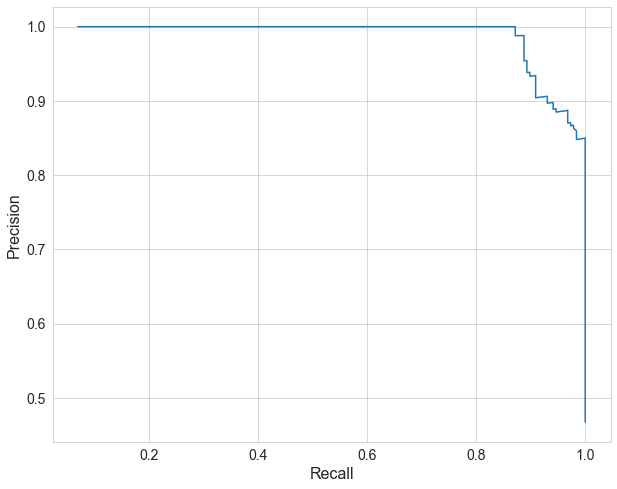

In [11]:
plt.figure(figsize=(10,8))

plt.plot(rec_scores, prec_scores)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

We can note that an algorithm that perfectly predicts the probability of the observations would produce a precision-recall curve that traces the upper right-hand corner of the unit square. This is not likely to happen in practice.

### Trade-off between precision and recall

While precision-recall curves may not look this nice in practice, the general trend that precision tends to decrease as recall increases is a mainstay in such plots. Returning to our web seach example, when the web search is less stringent on what results it considers relevant (i.e. a low probability cutoff) we will capture a greater portion of all of the relevant documents, but the fraction of our results that are actually relevant to us is lower (high recall with low precision). Conversely, when we make our web search more stringent (higher probability cutoff) we can be sure that the returned results are more likely to be relevant to our query, but we will have captured fewer of the overall relevant results (low recall with high precision).


We can also see the reason for the trade-off by reminding ourselves of the  precision and recall formulae:

$$
\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} \text{ and}
$$

$$
\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}.
$$

At a cutoff of $0$ every instance is classified as a $1$ and so $\text{recall} = 1$ and precision is equal to whatever percentage of the observations are of class $1$. Note that the denominator of recall is not impacted by the cutoff. Since the number of true positives decreases as the cutoff increases then the recall must also decrease (to $0$). Although the denominator of precision does depend upon the cutoff, the number of false positives will go to $0$ as we increase the cutoff and so the precision will tend to approach $1$ as we increase the cutoff.

With that in mind the precision-recall curve provides us a way to examine this trade-off and choose a cutoff that is appropriate for the needs of our problem.

## The receiver operating characteristic (ROC) curve

The <i>receiver operating characteristic</i> (ROC) curve arose in World War II as a way to aid operators of radar receivers for detecting enemy objects in battlefields. It plots the true positive rates (TPRs) against the false positive rates (FPRs) for various cutoff values. The curve for a specific algorithm is often compared to the theoretical ROC curve for a random guess algorithm which is the line $y=x$.

As a reminder the TPR is the same as the recall, so it measures the probability that an observation is classified as a $1$ when if it is actually a $1$, i.e. $P(\hat{y} = 1 | y =1)$. The FPR estimates the probability that an observation is classified as $1$ when it is actually a $0$, i.e. $P(\hat{y} = 1 | y = 0)$.

A nice analogy for these metrics comes from oncology. Sometimes people will have surgery to remove a tumor (a collection of cancerous cells). The goal of such surgeries is to maximize the amount of cancerous cells and minimize the amount of normal cells that are removed. If we treat cancerous cells as "class 1" observations and normal cells as "class 0"  then we can think of this as trying to maximimize TPR while minimizing FPR.

Below we demonstrate two methods of constructing this curve, one with a `for` loop and one using an `sklearn` function.

#### `for` loop

##### Exercise: Try to fill in the missing code in the next code chunk.

In [12]:
## for loop approach
cutoffs = np.arange(0,1,.001)

tprs = []
fprs = []

for cutoff in cutoffs:
    pred = 1*(log_reg.predict_proba(X_train.reshape(-1,1))[:,1] >= cutoff)
    
    conf_mat = confusion_matrix(y_train, pred)
    
    tn = conf_mat[0,0]
    fp = conf_mat[0,1]
    fn = conf_mat[1,0]
    tp = conf_mat[1,1]
    
    tprs.append(tp/(tp+fn))
    fprs.append(fp/(fp+tn))

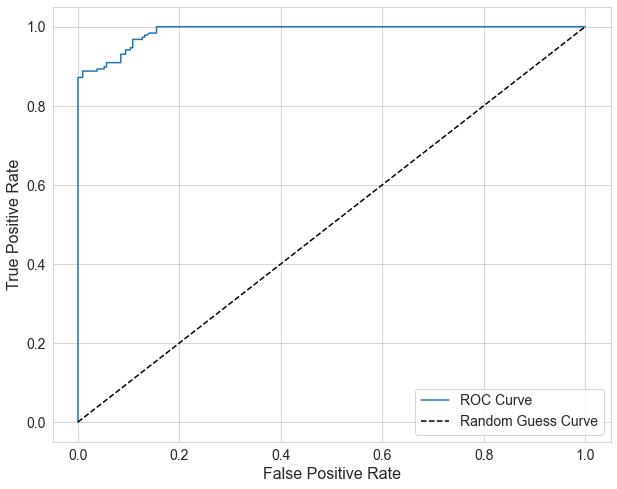

In [13]:
plt.figure(figsize=(10,8))

plt.plot(fprs, tprs, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")

plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.show()

#### With `sklearn`

`sklearn` has an `roc_curve` metric function that will generate curve points for you, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html">https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html</a>. However, with the function you have less control over the chosen cutoff values.

This returns three arrays, the false positive rates, the true positive rates and the cutoffs that are associated with those scores. Note that the cutoffs have an additional value in the `0` position of the array which is $1$ plus the largest cutoff value used.

In [14]:
from sklearn.metrics import roc_curve

In [16]:
## First input the true values
## Then input the predicted probability for class 1
## the fprs, tprs and cutoffs are returned in that order
fprs, tprs, cutoffs = roc_curve(y_train, log_reg.predict_proba(X_train.reshape(-1,1))[:,1])

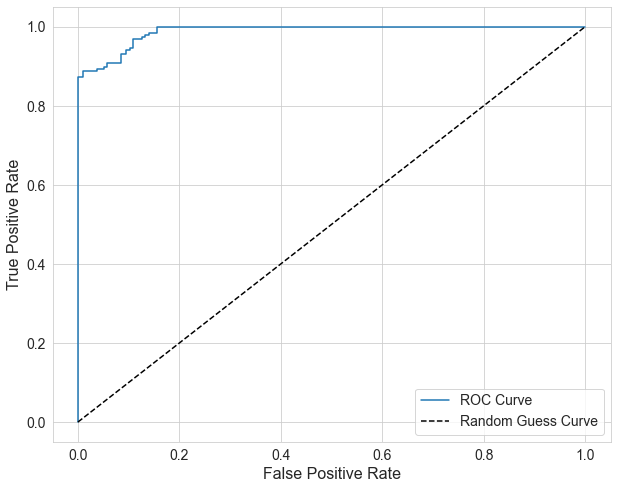

In [17]:
plt.figure(figsize=(10,8))

plt.plot(fprs, tprs, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.show()

A theoretical perfect classifier would have an ROC curve that hugs the upper left-hand corner of the unit square.

Remember that the TPR is the same as the sensitivity of the algorithm and the FPR is one minus the specifity. Thus the ROC curve is equivalent to plotting the sensitivity against the specifity.

In general as we increase the TPR we also increase the FPR. Returning to our cancer surgery example, if we get too ambitious targeting cancer cells, then we are more likely to accidentally remove a normal cell. Conversely, if we are too cautious we will miss too much of the tumor and the surgery will have been a failure. The ROC curve allows us to find the perfect balance for our particular problem.

## Gains and lift charts

The final plots we will introduce are called <i>gain</i> and <i>lift</i> charts.

The point of these curves is to give an estimate of the true positive rate of your algorithm if you classify the $v^\text{th}$ upper percentile of predicted probabilities and classify them as $1$.

A nice motivation for such a plot comes from marketing. Suppose that you only have the funds in your advertising budget to market to $v \%$ of your potential customers. You would want to allocate those ads in such a way that you maximize the number of people who see your ads and then become customers. In this setting we can take class $1$ to represent a person who would become a customer after seeing an ad and class $0$ as someone who would not become a customer after seeing an ad. By only marketing to those customers that fall in the top $v^\text{th}$ percentile of predicted probabilities, we will only market to those people our algorithm thinks are most likely to become a customer after seeing an ad.

### Gains chart

The gains chart plots the TPR as a function of the percent of observations we have classified as $1$. Similar to the ROC curve, it is typical to plot a "baseline" curve for comparison. Again the baseline is taken to be the line $y=x$, which represents us randomly selecting $v\%$ of the observations to be of class $1$.

### Lift chart

The lift chart is the ratio of the gains curve for the algorithm to the baseline curve. It is called a lift chart because this ratio is supposed to represent the "lift" the algorithm gives you over random guessing.

### Plotting in python

We can plot this in python using `pandas`'s `quantile` function, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html</a>.

<i>This can also be accomplished with `numpy`'s `quantile` function, <a href="https://numpy.org/doc/stable/reference/generated/numpy.quantile.html">https://numpy.org/doc/stable/reference/generated/numpy.quantile.html</a></i>.

In [18]:
pred_df = pd.DataFrame({'actual':y_train,
                           'prob':log_reg.predict_proba(X_train.reshape(-1,1))[:,1]})

In [19]:
## getting the p cutoffs using .quantile
## put in a number from 0 to 1 and recieve the 
## quantile for that number
ps = [pred_df.prob.quantile(i) for i in np.arange(1, 0, -0.01)]

In [20]:
## the first five upper probability quantiles
ps[:5]

[0.9786383130747738,
 0.9767360623815692,
 0.9751908749859657,
 0.9741094531860159,
 0.9705670074470456]

In [21]:
## Now we get the tprs for the corresponding quantiles
tprs = []
lifts = []


for i,p in enumerate(ps):
    pred = 1*(pred_df.prob.values >= p)
    
    ## using the fact the tpr is recall
    tprs.append(recall_score(pred_df.actual.values, pred))
    
## as well as the lift_scores
lifts = [tprs[i]/np.arange(.01,1.01,.01)[i] for i in range(100)]

In [22]:
len(tprs)

100

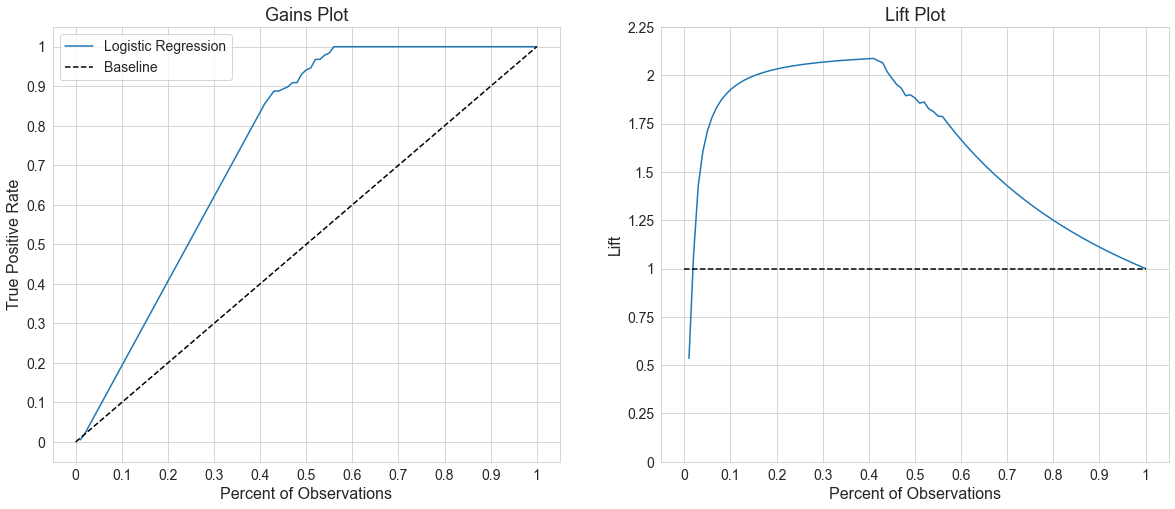

In [23]:
fig,ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(np.arange(0.01,1.01,0.01), tprs, label="Logistic Regression")
ax[0].plot([0,1], [0,1], 'k--', label="Baseline")

ax[0].set_xlabel("Percent of Observations", fontsize=16)
ax[0].set_ylabel("True Positive Rate", fontsize=16)
ax[0].set_xticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax[0].set_xticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], fontsize=14)
ax[0].set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax[0].set_yticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], fontsize=14)
ax[0].set_title("Gains Plot", fontsize=18)
ax[0].legend(fontsize=14)

ax[1].plot(np.arange(0.01,1.01,0.01), lifts)
ax[1].plot([0,1],[1,1],'k--')
ax[1].set_ylim((0,2.25))

ax[1].set_xlabel("Percent of Observations", fontsize=16)
ax[1].set_ylabel("Lift", fontsize=16)
ax[1].set_xticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax[1].set_xticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], fontsize=14)
ax[1].set_yticks([0,.25,.5,.75,1,1.25,1.5,1.75,2,2.25], fontsize=14)
ax[1].set_yticklabels([0,.25,.5,.75,1,1.25,1.5,1.75,2,2.25], fontsize=14)
ax[1].set_title("Lift Plot", fontsize=18)

plt.show()

If our model is any good it should generally lie above the Baseline curve. In particular the "best" model (i.e. the one that ranks all actual $1$s higher than all actual $0$s) should be the line from $(0,0)$ to $(r,1)$ where $r$ is the proportion of observations that are actually of class $1$.

The gains plot can be interpreted by drawing a vertical line at a given percent of observations. For example, by selecting the $20\%$ of observations most likely to be $1$, according to the model, we capture $40\%$ of the actual $1$s in the sample. 

Returning to our marketing motivation, this can be useful for setting expectations for what is obtainable with stakeholders. For example, if you are told that there is a budget for advertising to $20\%$ of all possible customers, you can reply that with this method of selecting ad targets we think we can get $40\%$ of the likely customers.

We should note that these plots say nothing about the false positive rate. In marketing you may not care too much about accidentally sending a few ads to people that will not become customers, but this is not the case in other applications. You may think to supplement the gains plot with a similar plot tracking false positive rate as a function of the percent of observations classified as $1$.

## Which curves or metrics?

When combined with our various individual metrics, a natural question is what curve or metric should you use for evaluating a model or method? There is no one-size-fits-all approach. What matters for one problem may not be important for another.

It is important to think about what is most important for your particular problem and select the metric(s) and curve(s) accordingly.

## A note on training sets

In this notebook we presented these curves using our training set. This was done for coding convenience. 

We should remember that in practice we are not usually interested performance metrics on a single training set. We are most interested in trying to estimate what the performance of the model will be on unknown data under the assumption that the unknown data follows the same distribution as our sample. Just like we can use a validation set or cross-validation to provide estimates of a single metric we can do a similar process for these diagnostic curves. That is, we can plot the curves using a validation set or plot a series of curves that result from cross-validation and examine their distribution.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)